In [1]:
import tensorflow as tf
import numpy as np
import math

print(f"Tensorflow version == {tf.__version__}")

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import time

from IPython.display import clear_output

tf.logging.set_verbosity(tf.logging.ERROR)

Tensorflow version == 1.13.1


In [6]:
#p(x|z)
def p_x(z): 
    return tf.random.normal(mean=2.0*z, stddev=0.1, shape = [1,2])

Pathwise derivative

$$E _ { z \sim q ( \cdot | x ) } \log p ( x | z ) \cdot \nabla _ { \theta } \log q ( z | x )$$


$$E _ { \epsilon \sim N (0 ,1 ) } \log p ( x | \epsilon ; \mu_{\theta},\sigma_{\theta} ) $$ 

In [47]:
tf.reset_default_graph()
'''Define placeholder for our target data'''
x = tf.placeholder(shape=[None, 2], dtype=tf.float32)

nn = tf.layers.dense(x, 10, activation=tf.nn.relu)
nn = tf.layers.dense(nn, 10, activation=tf.nn.relu)
nn = tf.layers.dense(nn, 10, activation=tf.nn.sigmoid)
mu = tf.layers.dense(nn, 2, activation=None)
sigma = tf.layers.dense(nn, 10, activation=tf.nn.relu)
sigma = tf.layers.dense(sigma, 2, activation=tf.nn.softplus) 

#mu,sigma = tf.squeeze(mu),tf.squeeze(sigma)

z_ =  mu + sigma * tf.random.normal(shape = [1,2])
x_ = p_x(z_)


'''But can we get z_samples from p(z|x) apriori'''
z = tf.random.normal(mean=0.5*x, stddev=0.05, shape = [1,2]) #samples from p(z\x)
encoder_loss = (((z_ - z)**2)/(2*sigma**2) + 0.5*tf.log(2*math.pi*sigma**2))

weight_term = (x - x_)**2
weight_term2 = tf.stop_gradient(weight_term)

#nll = tf.reduce_mean(encoder_loss * tf.stop_gradient(weight_term2)  )
nll = tf.reduce_mean(encoder_loss * weight_term  )

train_op = tf.train.GradientDescentOptimizer(0.001).minimize(nll)
init = tf.global_variables_initializer()

In [48]:
#tf.gradients(weight_term, tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

<>:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-49-225ef9247c19>:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (not np.isnan(nll_output),\


step : 0, mu : [0.06477159 0.68313617], std: [0.7236658  0.64382374], nll: 6772.576171875


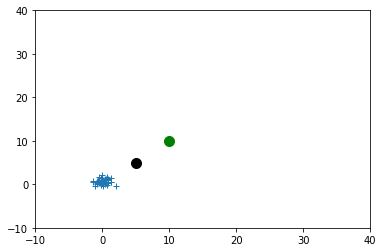

step : 10, mu : [8.704563 4.047025], std: [4.3043027 0.931592 ], nll: 150.21835327148438


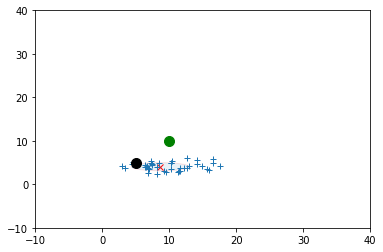

step : 20, mu : [-93.94664    4.402791], std: [910.6407      1.3505005], nll: 23865426.0


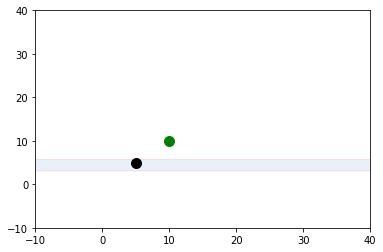

step : 30, mu : [100.48394     5.2985597], std: [623.20886     1.2517823], nll: 16576871.0


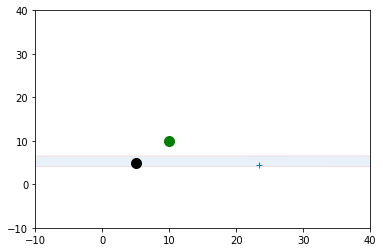

step : 40, mu : [-98.80246    4.908679], std: [419.6022      1.2094111], nll: 4666086.0


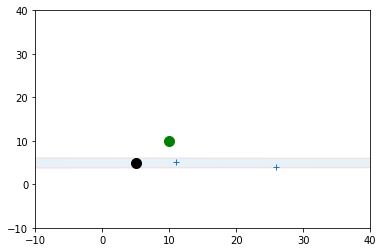

step : 50, mu : [-57.756157   5.167948], std: [174.23483     1.1754826], nll: 174356.15625


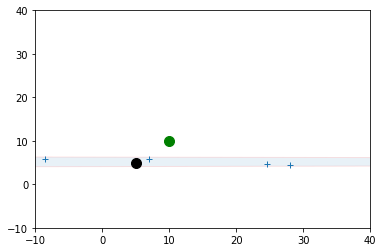

step : 60, mu : [2.5909693 5.1507416], std: [146.0064      1.1568049], nll: 2827661.0


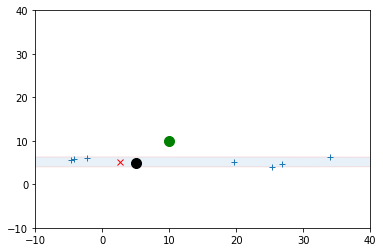

step : 70, mu : [8.769303  5.1715293], std: [83.737      1.1230702], nll: 4374.09033203125


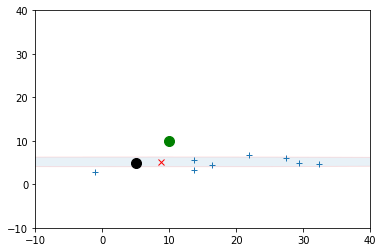

step : 80, mu : [-9.102956  5.184716], std: [76.149826   1.0453341], nll: 20704.56640625


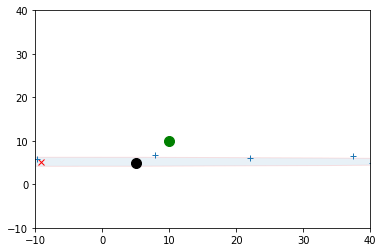

step : 90, mu : [0.8448479 5.12741  ], std: [57.374596  1.007635], nll: 9136.2490234375


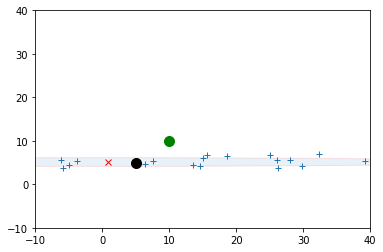

step : 100, mu : [-13.443723   5.023238], std: [45.863155   0.9901069], nll: 204938.265625


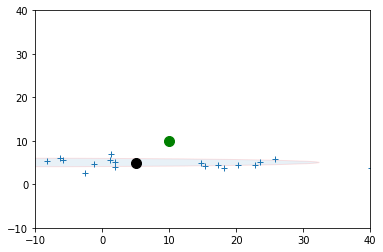

step : 110, mu : [34.85627   5.109241], std: [27.73433    0.9688927], nll: 6458.4931640625


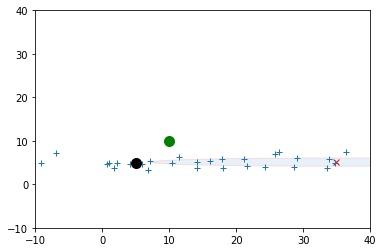

step : 120, mu : [8.731758  4.8899355], std: [22.590813    0.93618864], nll: 9948.4697265625


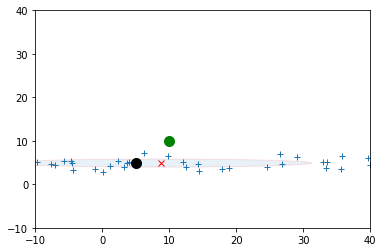

step : 130, mu : [-1.2739178  4.802869 ], std: [19.143608   0.9032498], nll: 10408.23828125


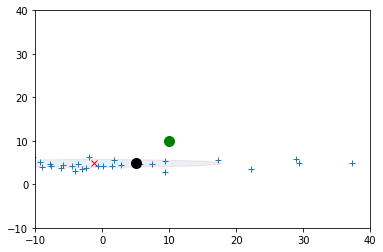

step : 140, mu : [7.893957  4.9675584], std: [16.122017   0.8892084], nll: 650.7534790039062


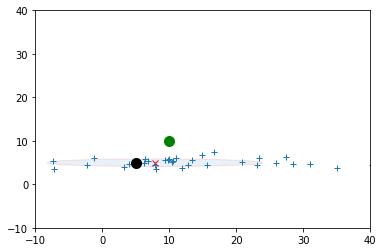

step : 150, mu : [5.785977  4.3282332], std: [12.846856  0.792204], nll: 52.58884048461914


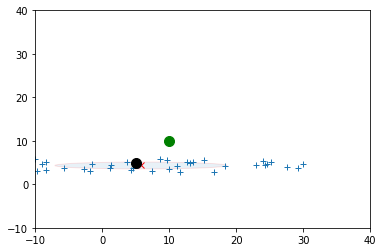

step : 160, mu : [-0.29736495  4.8361845 ], std: [9.500203  0.7753197], nll: 27.072391510009766


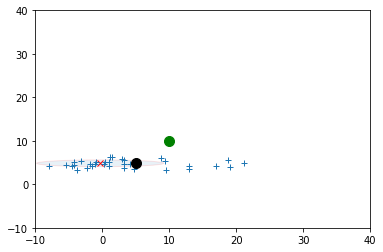

step : 170, mu : [2.9322495 5.1362157], std: [8.754525   0.75742054], nll: 3079.576904296875


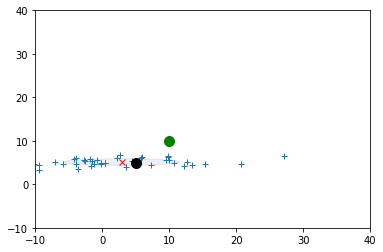

step : 180, mu : [4.0870676 5.4088798], std: [7.2916327  0.73534197], nll: 556.7433471679688


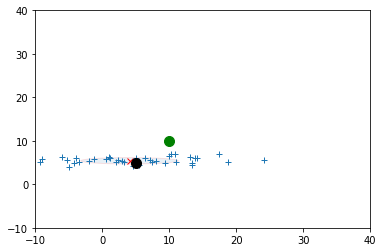

step : 190, mu : [6.6762915 4.8561726], std: [6.1166043 0.7217283], nll: 57.77857971191406


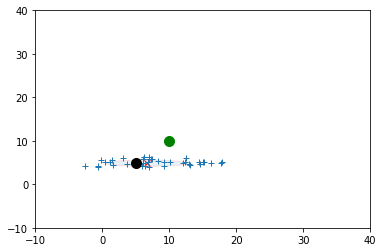

KeyboardInterrupt: 

In [49]:
target_mu,target_sigma = 10.0,0.5
population = 40

batch_size = 1


with tf.Session() as sess:
    sess.run(init)
    for step in range(5000):
        p_data_samples = np.random.normal(target_mu, target_sigma, (batch_size, 2))
        _, mu_output, std_output, nll_output = sess.run([train_op,mu,sigma, nll], feed_dict={x: p_data_samples})
        
        assert (not np.isnan(nll_output),\
        "unstable training: gradient exploded - a common pitfall when using the score function\
        as the variance is too high")
        
        if step % 10 ==0:
            
            clear_output(wait=True)
            print(f"step : {step}, mu : {mu_output[0]}, std: {std_output[0]}, nll: {nll_output}")            
            
            el = Ellipse(xy=mu_output[0], width=2*std_output[0][0], height=2*std_output[0][1], angle=0, alpha=0.1)
            el.set_edgecolor('red')
            plt.gca().add_artist(el)
            plt.plot(mu_output[0][0],mu_output[0][1], 'rx', label='mean')
            
            output_samples = sess.run(tf.random.normal(mean= mu_output[0], stddev=std_output[0], shape = [population,2]))
            plt.plot(output_samples[:,0], output_samples[:,1], '+')
            plt.plot(target_mu, target_mu, 'g.', ms=20, label='target_samp')
            
            plt.plot(target_mu/2, target_mu/2, 'k.', ms=20, label='target_samp')
            
            plt.axis([-10, 40, -10, 40])
            plt.show()
            plt.pause(1)
            
            
        


$$E _ { \epsilon \sim N (0 ,1 ) } \log p ( x | \epsilon ; \mu_{\theta},\sigma_{\theta} ) $$ 

In [17]:
tf.reset_default_graph()

In [34]:
tf.reset_default_graph()

x = tf.placeholder(shape=[None, 2], dtype=tf.float32)

nn = tf.layers.dense(x, 10, activation=tf.nn.relu)
nn = tf.layers.dense(nn, 10, activation=tf.nn.relu)
nn = tf.layers.dense(nn, 10, activation=tf.nn.sigmoid)
mu = tf.layers.dense(nn, 2, activation=None)
sigma = tf.layers.dense(nn, 10, activation=tf.nn.relu)
sigma = tf.layers.dense(sigma, 2, activation=tf.nn.softplus) 

z =  mu + sigma * tf.random.normal(shape = [1,2])
x_ = p_x(z)

nll_cost = tf.reduce_mean(((x_ - x)**2)/(2*sigma**2) + 0.5*tf.log(2*math.pi*sigma**2))
train_op = tf.train.GradientDescentOptimizer(0.005).minimize(nll_cost)
init = tf.global_variables_initializer()

step : 0,mu : [0.47591567 1.0522406 ], std: [0.9466329  0.60828495], nll: 64.96885681152344


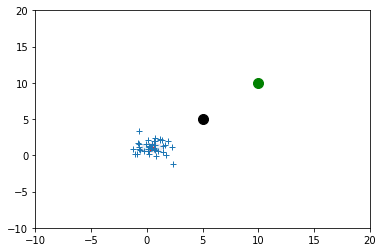

step : 20,mu : [2.2338252 2.021775 ], std: [4.1317725 3.2222745], nll: 5.63983678817749


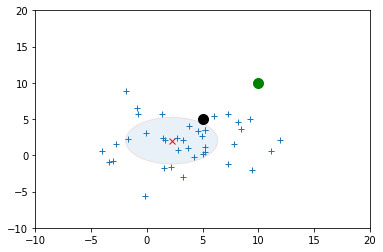

step : 40,mu : [2.5436485 2.2202635], std: [4.45166   3.7034216], nll: 4.787474155426025


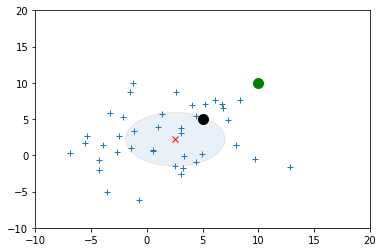

step : 60,mu : [2.8210685 2.3793087], std: [4.6247625 3.9598987], nll: 5.350264072418213


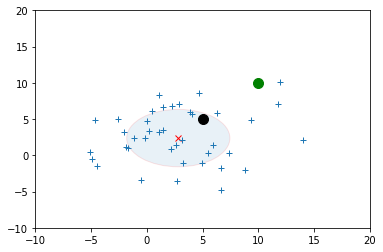

step : 80,mu : [2.822661  2.8172936], std: [4.634992  4.2864847], nll: 6.490564346313477


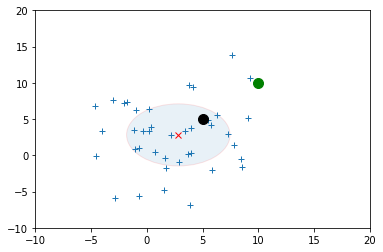

step : 100,mu : [2.8975    3.0474126], std: [4.507608 4.238976], nll: 4.890577793121338


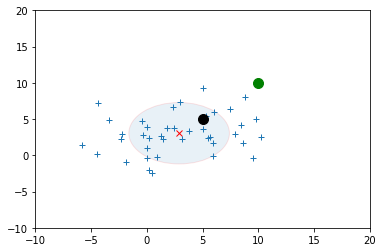

step : 120,mu : [2.9684064 3.447072 ], std: [4.5769114 4.261237 ], nll: 3.00065279006958


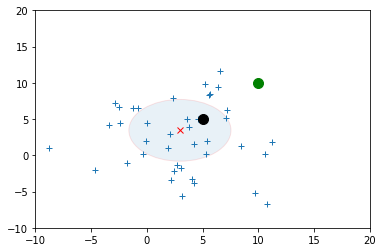

step : 140,mu : [3.0504518 3.7028096], std: [4.4743996 4.109527 ], nll: 6.96038818359375


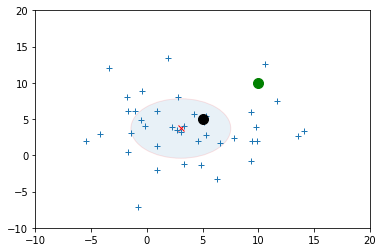

step : 160,mu : [3.197116 3.980958], std: [4.425211  3.9584305], nll: 4.096623420715332


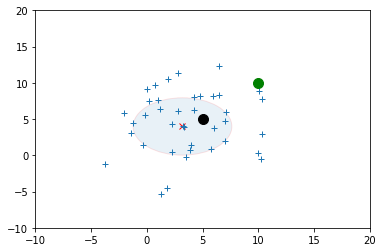

step : 180,mu : [3.420142  4.0494933], std: [4.3133636 3.762348 ], nll: 2.503387451171875


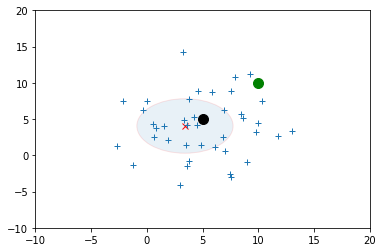

step : 200,mu : [3.4890049 3.8739545], std: [3.9498355 3.33241  ], nll: 3.519040584564209


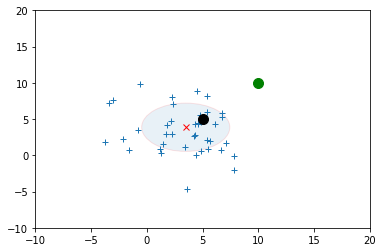

step : 220,mu : [3.7952566 4.0701222], std: [3.9153457 3.23895  ], nll: 3.6047186851501465


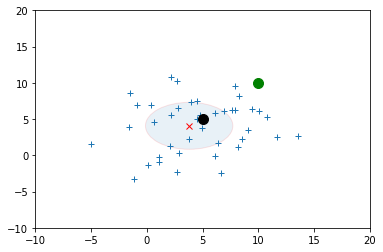

step : 240,mu : [3.8148155 4.144602 ], std: [3.6269069 2.9455397], nll: 5.869178771972656


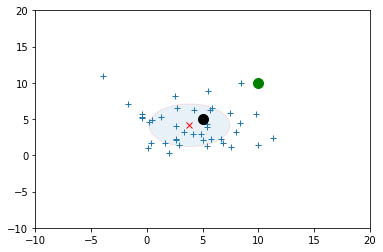

step : 260,mu : [3.8594692 4.5726566], std: [3.4523525 2.7749386], nll: 2.493906021118164


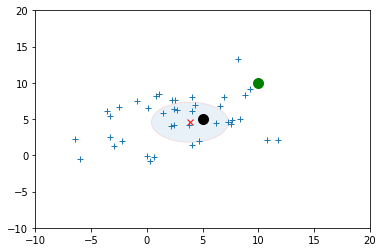

step : 280,mu : [3.917581 4.515116], std: [3.0808089 2.449111 ], nll: 2.9236583709716797


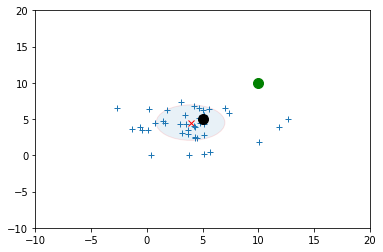

step : 300,mu : [4.1646147 4.811566 ], std: [2.9403737 2.2322242], nll: 2.5253026485443115


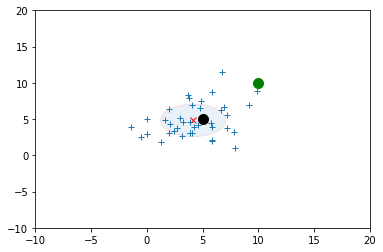

KeyboardInterrupt: 

In [35]:
target_mu,target_sigma = 10.0,0.5
population = 40

batch_size = 1

with tf.Session() as sess:
    sess.run(init)
    for step in range(10000):
        p_data_samples = np.random.normal(target_mu, target_sigma, (batch_size, 2))
        _, mu_output, std_output, hop = sess.run([train_op,mu,sigma, nll_cost], feed_dict={x: p_data_samples})
        #
        if step % 20 ==0:
            
            clear_output(wait=True)
            #print(f"step : {step}, mu : {mu_output}, std: {std_output}, nll: {hop}")
            print(f"step : {step},mu : {mu_output[0]}, std: {std_output[0]}, nll: {hop}")
            
            el = Ellipse(xy=mu_output[0], width=2*std_output[0][0], height=2*std_output[0][1], angle=0, alpha=0.1)
            el.set_edgecolor('red')
            plt.gca().add_artist(el)
            plt.plot(mu_output[0][0],mu_output[0][1], 'rx', label='mean')
            
            output_samples = sess.run(tf.random.normal(mean= mu_output[0], stddev=std_output[0], shape = [population,2]))
            plt.plot(output_samples[:,0], output_samples[:,1], '+')
            plt.plot(target_mu, target_mu, 'g.', ms=20, label='target_samp')
            
            plt.plot(target_mu/2, target_mu/2, 'k.', ms=20, label='target_samp')


            plt.axis([-10, 20, -10, 20])
            plt.show()
            plt.pause(1)
            
        


### TODO: 

- plot mu over steps

- stdv from PD and SF dont converge to same point - why?